## Case Datarisk

#### Objetivo:
- Criar um modelo preditivo calculando a probabilidade de inadimplencia de cada novo pedido de crédito.

#### Dados Fornecidos:
Arquivos CSV separados em treino e teste, contendo:

- idade: Idade;
- numero_de_dependentes: Numero de Dependentes;
- salario_mensal: Salário Mensal;
- numero_emprestimos_imobiliarios: Numero de empréstimos Imobiliários;
- numero_vezes_passou_90_dias: Numero de vezes que o tomador passou mais de 90 disa em atraso;
- util_linhas_inseguras: Quanto do limite não segurado disponível o tomador está utilizando;
- vezes_passou_de_30_59_dias: Numero de vezes que o cliente atrasou entre 30 e 59 dias o pagamento de um empréstimo;
- razao_debito: Razão entre dívidas e patrimonio do tomador.
- numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.
- numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente
atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.

#### Avaliação:
- Código;
- Desempenho do modelo;
- Raciocínio;

#### Metodologia de Resolução:
1. Importação dos dados e possíveis transformações;
2. Análise dos dados faltantes e outliers;
3. Limpeza da Base;
4. Teste de Correlação entre as Features;
4. Treino dos modelos;
5. Avaliação dos modelos;
6. Aplicação do melhor modelo na base de teste;

#### Considerações
Como o objetivo é devolver a probabilidade de inadimplecia dos clientes, vou utilizar os métodos supervisionados de classificação para resolver esse problema.
Testaremos os seguintes métodos:
- Regressão Logística;
- KNN;
- Gaussian Naive Bayes
- Multinomial Naive Bayes
- Decision Tree Classifier
- Dummy Classifier (para comparação dos resultados)

In [199]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [189]:
#Funcoes

def tirando_NA(df, coluna:str):
    print(f'Apagando --> {df[coluna].isna().sum()}')
    return df[df[coluna].notna()]

def convertendo_int(df, coluna:str):
    df[coluna]=df[coluna].apply(lambda x: int(x))
    print(f'Transformando --> {df[coluna].dtype}')
    return df

def boxplot(df, x):
    sns.boxplot(data = df, x = x)
    
def matriz_confusao(nome_modelo, modelo, X_test, y_test):
    y_previsto = modelo.predict(X_test)
    y_previsto_proba = modelo.predict_proba(X_test)[::, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_previsto_proba)
    cf_matrix = confusion_matrix(y_test, y_previsto)
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title(f'Matriz Confusão - {nome_modelo} \n')
    ax.set_xlabel('\nValores Preditos')
    ax.set_ylabel('Valores Reais')

    # Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Falso', 'Verdadeiro'])
    ax.yaxis.set_ticklabels(['Falso', 'Verdadeiro'])

    # Display the visualization of the Confusion Matrix.
    plt.show()
    
def coeficientes_modelo(modelo, X_train, y_train):
    intercepto = modelo.fit(X_train, y_train).intercept_
    print(f'O intercepto é {intercepto}')
    coeficientes = modelo.fit(X_train, y_train).coef_.tolist()
    features = list(X_train.columns)
    print('Feature --> Coeficiente\n')
    for i, feature in enumerate(features):
        print(f'{feature} --> {coeficientes[0][i]}\n')
        
        
def Remove_Outlier_Indices(df):
    # https://stackoverflow.com/questions/46245035/pandas-dataframe-remove-outliers
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return trueList
    
def dummyClasifier(X_train, y_train, X_test, y_test):
    modeloDummy = DummyClassifier(strategy='most_frequent')
    modeloDummy.fit(X_train, y_train)
    y_predicted = modeloDummy.predict(X_test)
    scoreDummy = modeloDummy.score(X_test, y_test)
    print(f'O score para o modelo Dummy Classifier é {scoreDummy}')
    

def regressaoLogistica(X_train, y_train, X_test, y_test):
    modeloRL = LogisticRegression()
    modeloRL.fit(X_train, y_train)
    y_predicted = modeloRL.predict(X_test)
    scoreRL = modeloRL.score(X_test, y_test)
    print(f'O score para o modelo de Regressão Logística é {scoreRL}')
    

def KNNClassifier(X_train, y_train, X_test, y_test):
    modeloKNN = KNeighborsClassifier()
    modeloKNN.fit(X_train, y_train)
    scoreKNN = modeloKNN.score(X_test, y_test)
    print(f'O score para o modelo de Regressão Logística é {scoreKNN}')
    

def decisionTree(X_train, y_train, X_test, y_test):
    modeloTree = DecisionTreeClassifier()
    modeloTree.fit(X_train, y_train)
    scoreTree = modeloTree.score(X_test, y_test)
    print(f'O score para o modelo de Regressão Logística é {scoreTree}')
    

def gaussianNB(X_train, y_train, X_test, y_test):
    modeloGNB = GaussianNB()
    modeloGNB.fit(X_train, y_train)
    scoreGNB = modeloGNB.score(X_test, y_test)
    print(f'O score para o modelo de Regressão Logística é {scoreGNB}')
    

def multinomialNB(X_train, y_train, X_test, y_test):
    modeloMNB = MultinomialNB()
    modeloMNB.fit(X_train, y_train)
    scoreMNB = modeloMNB.score(X_test, y_test)
    print(f'O score para o modelo de Regressão Logística é {scoreMNB}')


#### 1. Importação dos dados e possíveis transformações;


In [147]:
treino = pd.read_csv('treino.csv')
teste = pd.read_csv('teste.csv')

In [148]:
#Analisando Treino
treino.head(10)

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [149]:
#Tamanho das bases
print(f'BASE TREINO --> {treino.shape}')
print(f'BASE TESTE --> {teste.shape}')


BASE TREINO --> (110000, 11)
BASE TESTE --> (40000, 10)


In [150]:
print(f'Tipos de dados para dados de TREINO:\n {treino.dtypes}\n\n')
print(f'Tipos de dados para dados de TESTE:\n {teste.dtypes}')


Tipos de dados para dados de TREINO:
 inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object


Tipos de dados para dados de TESTE:
 util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobilia

Analisando os tipos de dados, tanto de teste como de treino, poderá ser transformado o numero de dependentes para uma valor int.
Para transfomar para int tenho que tirar os valores NA e inf da base, para isso tenho algumas opções:
- Tirar toda a linhda correspondente aos dados faltantes da base;
- Associar um valor médio ou menos zero para os dados ausente.

Minha primeira aproximação será retirando dos valores NA e inf da base;

In [151]:
#Retirando os valores NA da base de treino e teste
treino = tirando_NA(treino, 'numero_de_dependentes')
teste = tirando_NA(teste, 'numero_de_dependentes')

#Transformando em int:
treino = convertendo_int(treino, 'numero_de_dependentes')
teste = convertendo_int(teste, 'numero_de_dependentes')

print(f'\n\nTipos de dados para dados de TREINO:\n {treino.dtypes}\n\n')
print(f'Tipos de dados para dados de TESTE:\n {teste.dtypes}')

Apagando --> 2878
Apagando --> 1046
Transformando --> int64
Transformando --> int64


Tipos de dados para dados de TREINO:
 inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                      int64
dtype: object


Tipos de dados para dados de TESTE:
 util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto             

Finalizei a primeira etapa e transformei os dados de numero de dependetes em int tanto da base de TREINO como da TESTE, apagando os dados NA.

#### 2. Análise dos dados faltantes e outliers;


In [152]:
print(f'Informações TREINO:\n {treino.info()}\n\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107122 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           107122 non-null  int64  
 1   util_linhas_inseguras                  107122 non-null  float64
 2   idade                                  107122 non-null  int64  
 3   vezes_passou_de_30_59_dias             107122 non-null  int64  
 4   razao_debito                           107122 non-null  float64
 5   salario_mensal                         88237 non-null   float64
 6   numero_linhas_crdto_aberto             107122 non-null  int64  
 7   numero_vezes_passou_90_dias            107122 non-null  int64  
 8   numero_emprestimos_imobiliarios        107122 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  107122 non-null  int64  
 10  numero_de_dependentes                  107122 non-null  

In [153]:
print(f'Informações TESTE:\n {teste.info()}\n\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38954 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   util_linhas_inseguras                  38954 non-null  float64
 1   idade                                  38954 non-null  int64  
 2   vezes_passou_de_30_59_dias             38954 non-null  int64  
 3   razao_debito                           38954 non-null  float64
 4   salario_mensal                         32032 non-null  float64
 5   numero_linhas_crdto_aberto             38954 non-null  int64  
 6   numero_vezes_passou_90_dias            38954 non-null  int64  
 7   numero_emprestimos_imobiliarios        38954 non-null  int64  
 8   numero_de_vezes_que_passou_60_89_dias  38954 non-null  int64  
 9   numero_de_dependentes                  38954 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 3.3 MB
Informações TESTE:
 None


In [154]:
print(f"TREINO: \n {treino.isnull().sum()}\n\n")
print(f"TESTE: \n {teste.isnull().sum()}")

TREINO: 
 inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           18885
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                        0
dtype: int64


TESTE: 
 util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           6922
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes              

PROBLEMA: Como é possível analisar existem valores nulos na Feature salario_mensal em ambas as bases, e assim como com os dados de dependentes temos algumas escolhas de como preencher esses valores. Nesse primeiro momento irei apagar os valores da base e treinar o modelo sem estes valores.

In [155]:
treino = tirando_NA(treino, 'salario_mensal')
teste = tirando_NA(teste, 'salario_mensal')
print(f"\nTREINO: \n {treino.isnull().sum()}\n\n")
print(f"TESTE: \n {teste.isnull().sum()}")


Apagando --> 18885
Apagando --> 6922

TREINO: 
 inadimplente                             0
util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64


TESTE: 
 util_linhas_inseguras                    0
idade                                    0
vezes_passou_de_30_59_dias               0
razao_debito                             0
salario_mensal                           0
numero_linhas_crdto_aberto               0
numero_vezes_passou_90_dias              0
numero_emprestimos_imobiliarios          0
numero_de_vezes_que_passou_60_89_dias    0
numero_de_dependentes                    0
dtype: int64


Dataframes sem valores NA, portanto vou começar a analise de outliers, para isso irei utilizar ferramentas visuais.

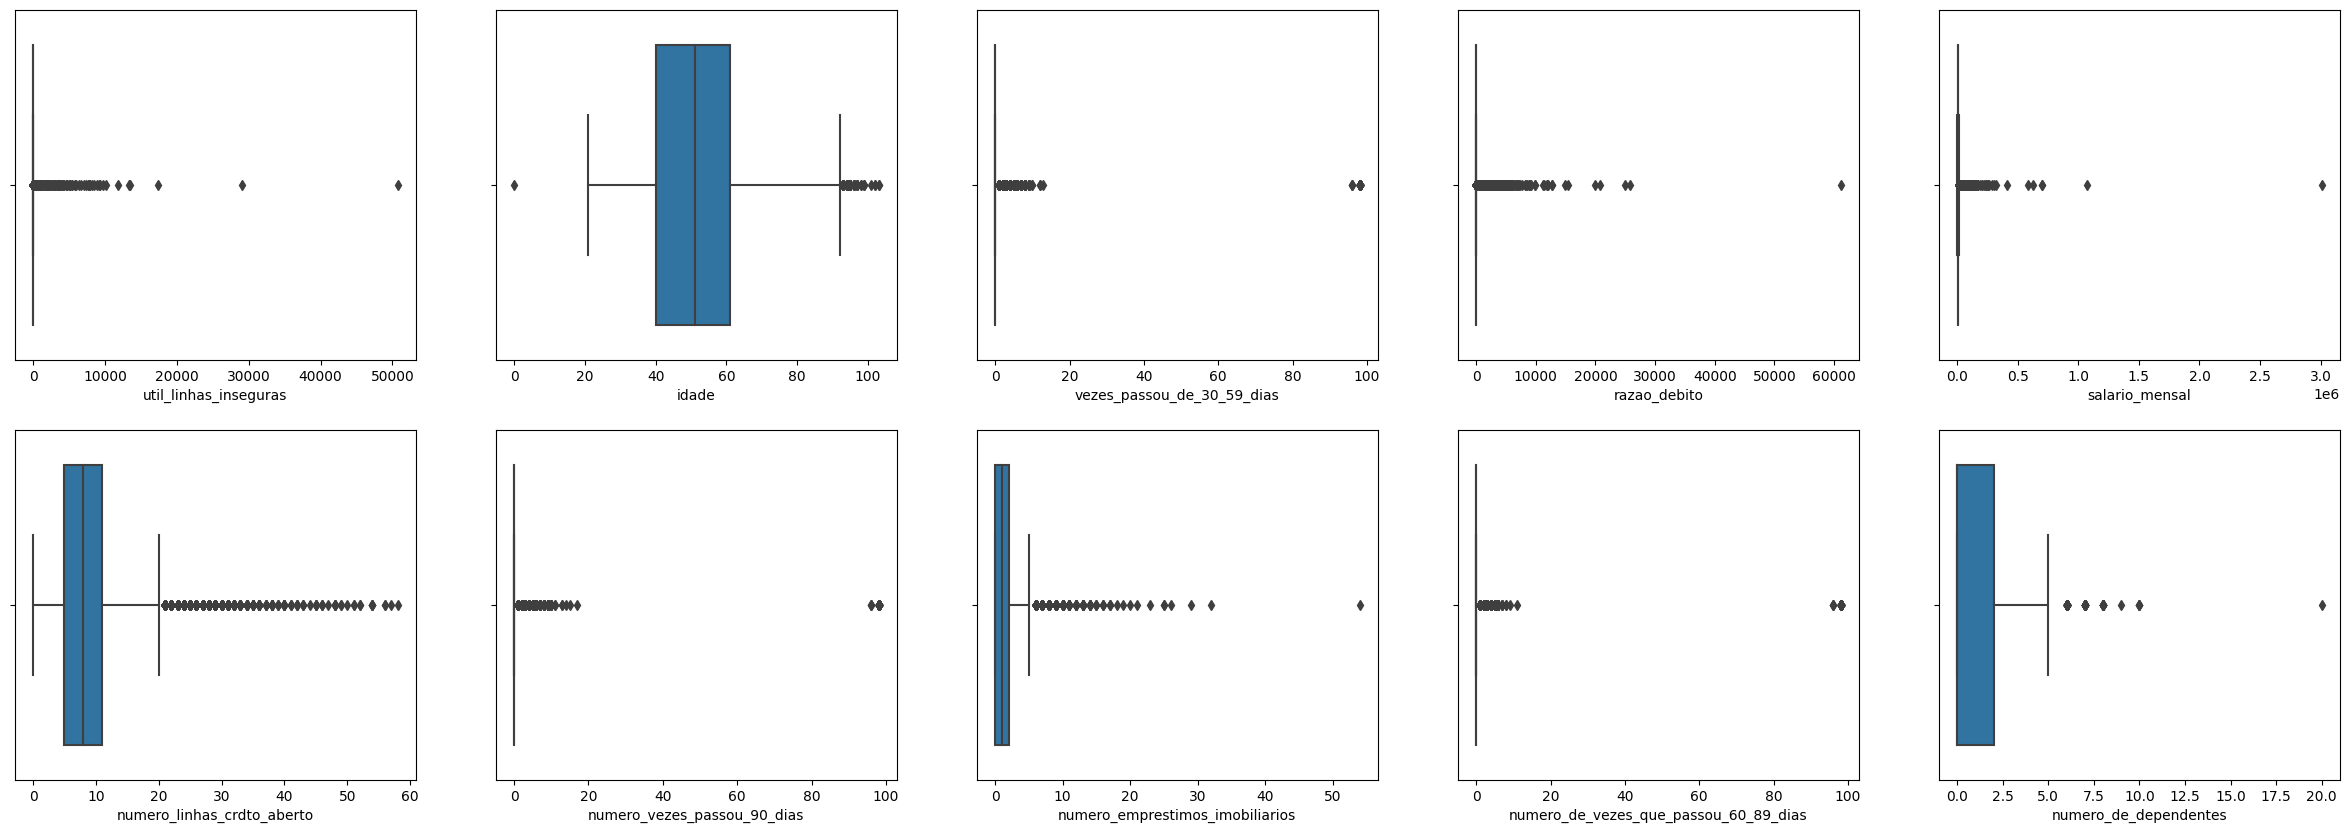

In [156]:
area = plt.figure(figsize=(30,10), dpi=100)
plot_idd = area.add_subplot(2, 5, 1)
plot_idd = boxplot(treino, x='util_linhas_inseguras')

#plot_idd.set_ylabel('Idade (anos)')
plot_func = area.add_subplot(2, 5, 2)
boxplot(treino, x='idade')

plot_meses = area.add_subplot(2, 5, 3)
boxplot(treino, x='vezes_passou_de_30_59_dias')

plot_meses = area.add_subplot(2, 5, 4)
boxplot(treino, x='razao_debito')

plot_meses = area.add_subplot(2, 5, 5)
boxplot(treino, x='salario_mensal')

plot_meses = area.add_subplot(2, 5, 6)
boxplot(treino, x='numero_linhas_crdto_aberto')

plot_meses = area.add_subplot(2, 5, 7)
boxplot(treino, x='numero_vezes_passou_90_dias')

plot_meses = area.add_subplot(2, 5, 8)
boxplot(treino, x='numero_emprestimos_imobiliarios')

plot_meses = area.add_subplot(2, 5, 9)
boxplot(treino, x='numero_de_vezes_que_passou_60_89_dias')

plot_meses = area.add_subplot(2, 5, 10)
boxplot(treino, x='numero_de_dependentes')



Alguns gráficos não ficaram claros, mas já dá pra ter algumas ideias dos gráficos disponíveis:

- util_linhas_inseguras: analisar melhor
- idade: 20 até 80 (ninguem pede emprestimo com 0 anos e pode ser fraude com mais de 90)
- vezes_passou_de_30_59_dias: 0 a 20
- salario_mensal: precisa analisar melhor
- numero_linhas_crdto_aberto: não vou alterar
- numero_vezes_passou_90_dias: 0 a 20
- numero_emprestimos_imobiliarios: 0a 20
- numero_de_vezes_que_passou_60_89_dias: 0 a 20
- numero_de_dependentes: nao vou modificar

#### 3. Limpeza da Base  

In [157]:
treino_sem_outliers = treino.query('20<=idade<=80').query(
    'vezes_passou_de_30_59_dias<=20').query('numero_vezes_passou_90_dias<=20').query('numero_de_vezes_que_passou_60_89_dias<=20').query('numero_emprestimos_imobiliarios<=20')
treino_sem_outliers

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
109992,0,0.006491,61,0,0.004570,3500.0,8,0,0,0,0
109995,0,0.137396,59,1,0.448912,9600.0,10,0,2,0,0
109996,0,0.276964,46,0,0.491288,12224.0,19,0,4,0,4
109997,0,0.181257,43,0,0.382635,12000.0,13,0,2,0,2


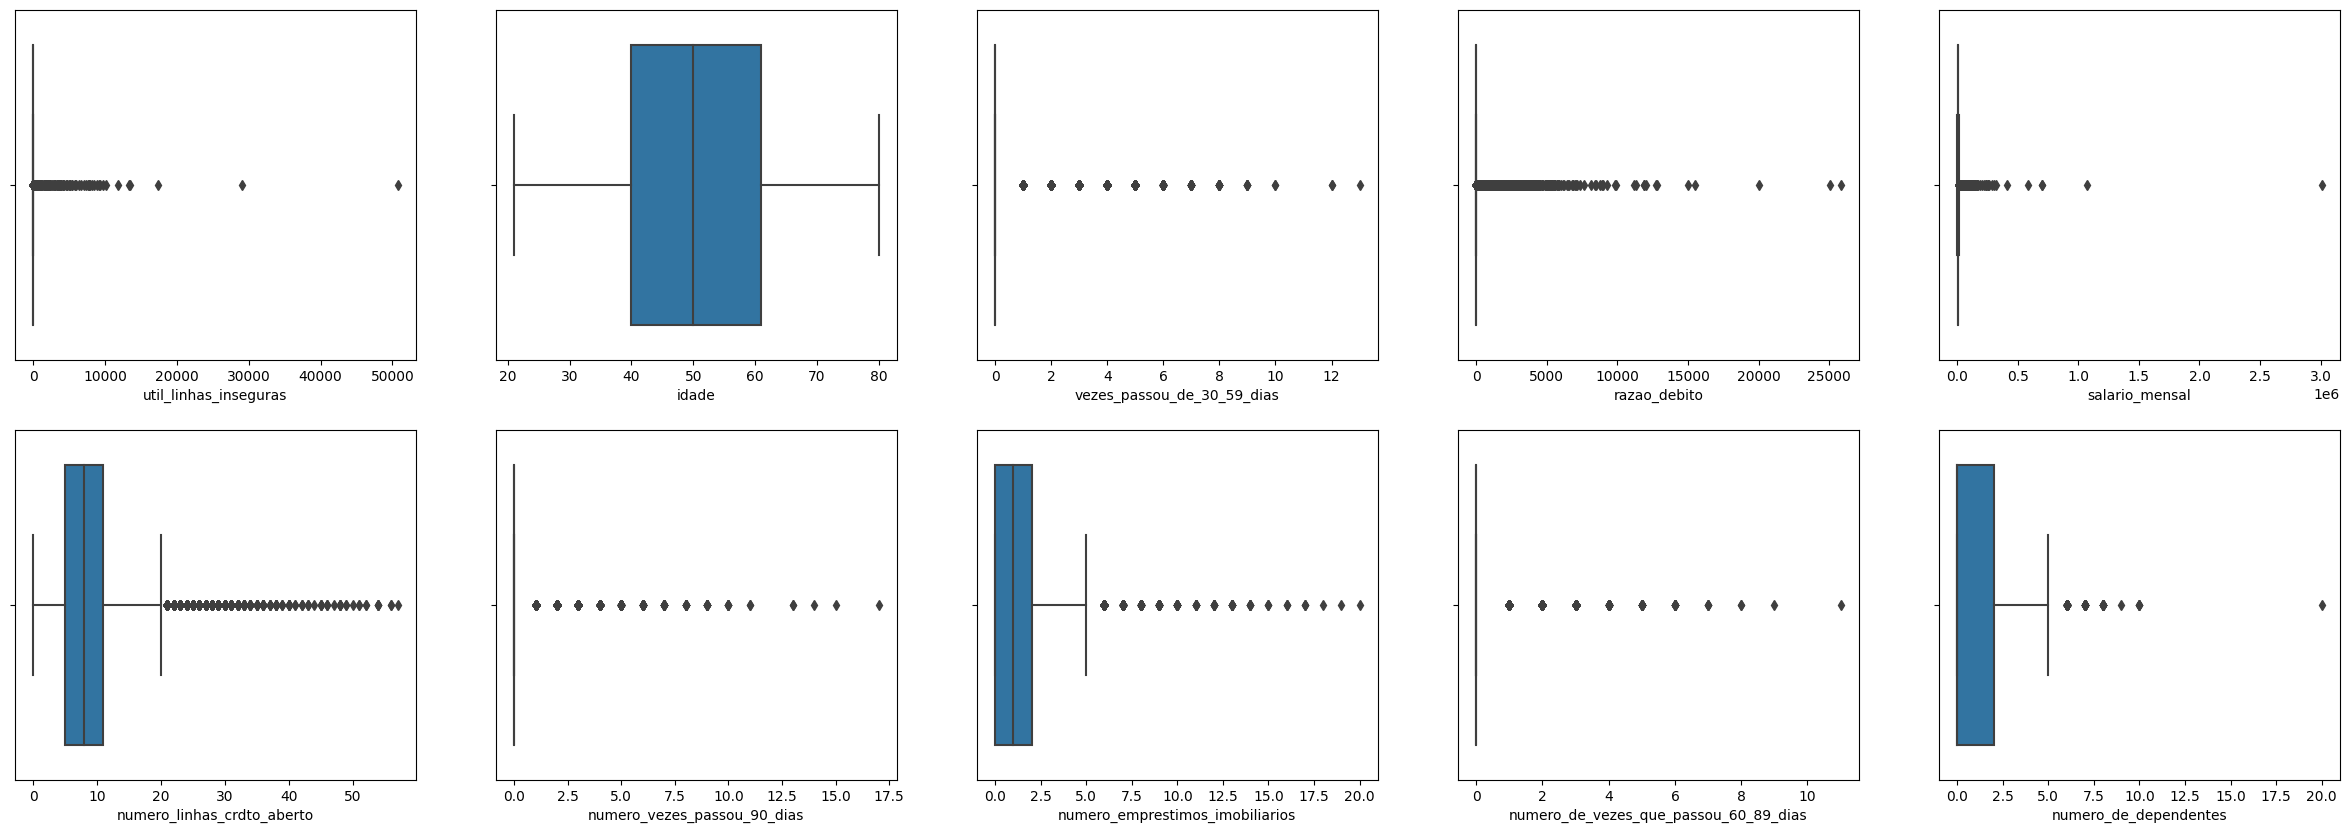

In [158]:
area = plt.figure(figsize=(30, 10), dpi=100)
plot_idd = area.add_subplot(2, 5, 1)
plot_idd = boxplot(treino_sem_outliers, x='util_linhas_inseguras')

# plot_idd.set_ylabel('Idade (anos)')
plot_func = area.add_subplot(2, 5, 2)
boxplot(treino_sem_outliers, x='idade')

plot_meses = area.add_subplot(2, 5, 3)
boxplot(treino_sem_outliers, x='vezes_passou_de_30_59_dias')

plot_meses = area.add_subplot(2, 5, 4)
boxplot(treino_sem_outliers, x='razao_debito')

plot_meses = area.add_subplot(2, 5, 5)
boxplot(treino_sem_outliers, x='salario_mensal')

plot_meses = area.add_subplot(2, 5, 6)
boxplot(treino_sem_outliers, x='numero_linhas_crdto_aberto')

plot_meses = area.add_subplot(2, 5, 7)
boxplot(treino_sem_outliers, x='numero_vezes_passou_90_dias')

plot_meses = area.add_subplot(2, 5, 8)
boxplot(treino_sem_outliers, x='numero_emprestimos_imobiliarios')

plot_meses = area.add_subplot(2, 5, 9)
boxplot(treino_sem_outliers, x='numero_de_vezes_que_passou_60_89_dias')

plot_meses = area.add_subplot(2, 5, 10)
boxplot(treino_sem_outliers, x='numero_de_dependentes')


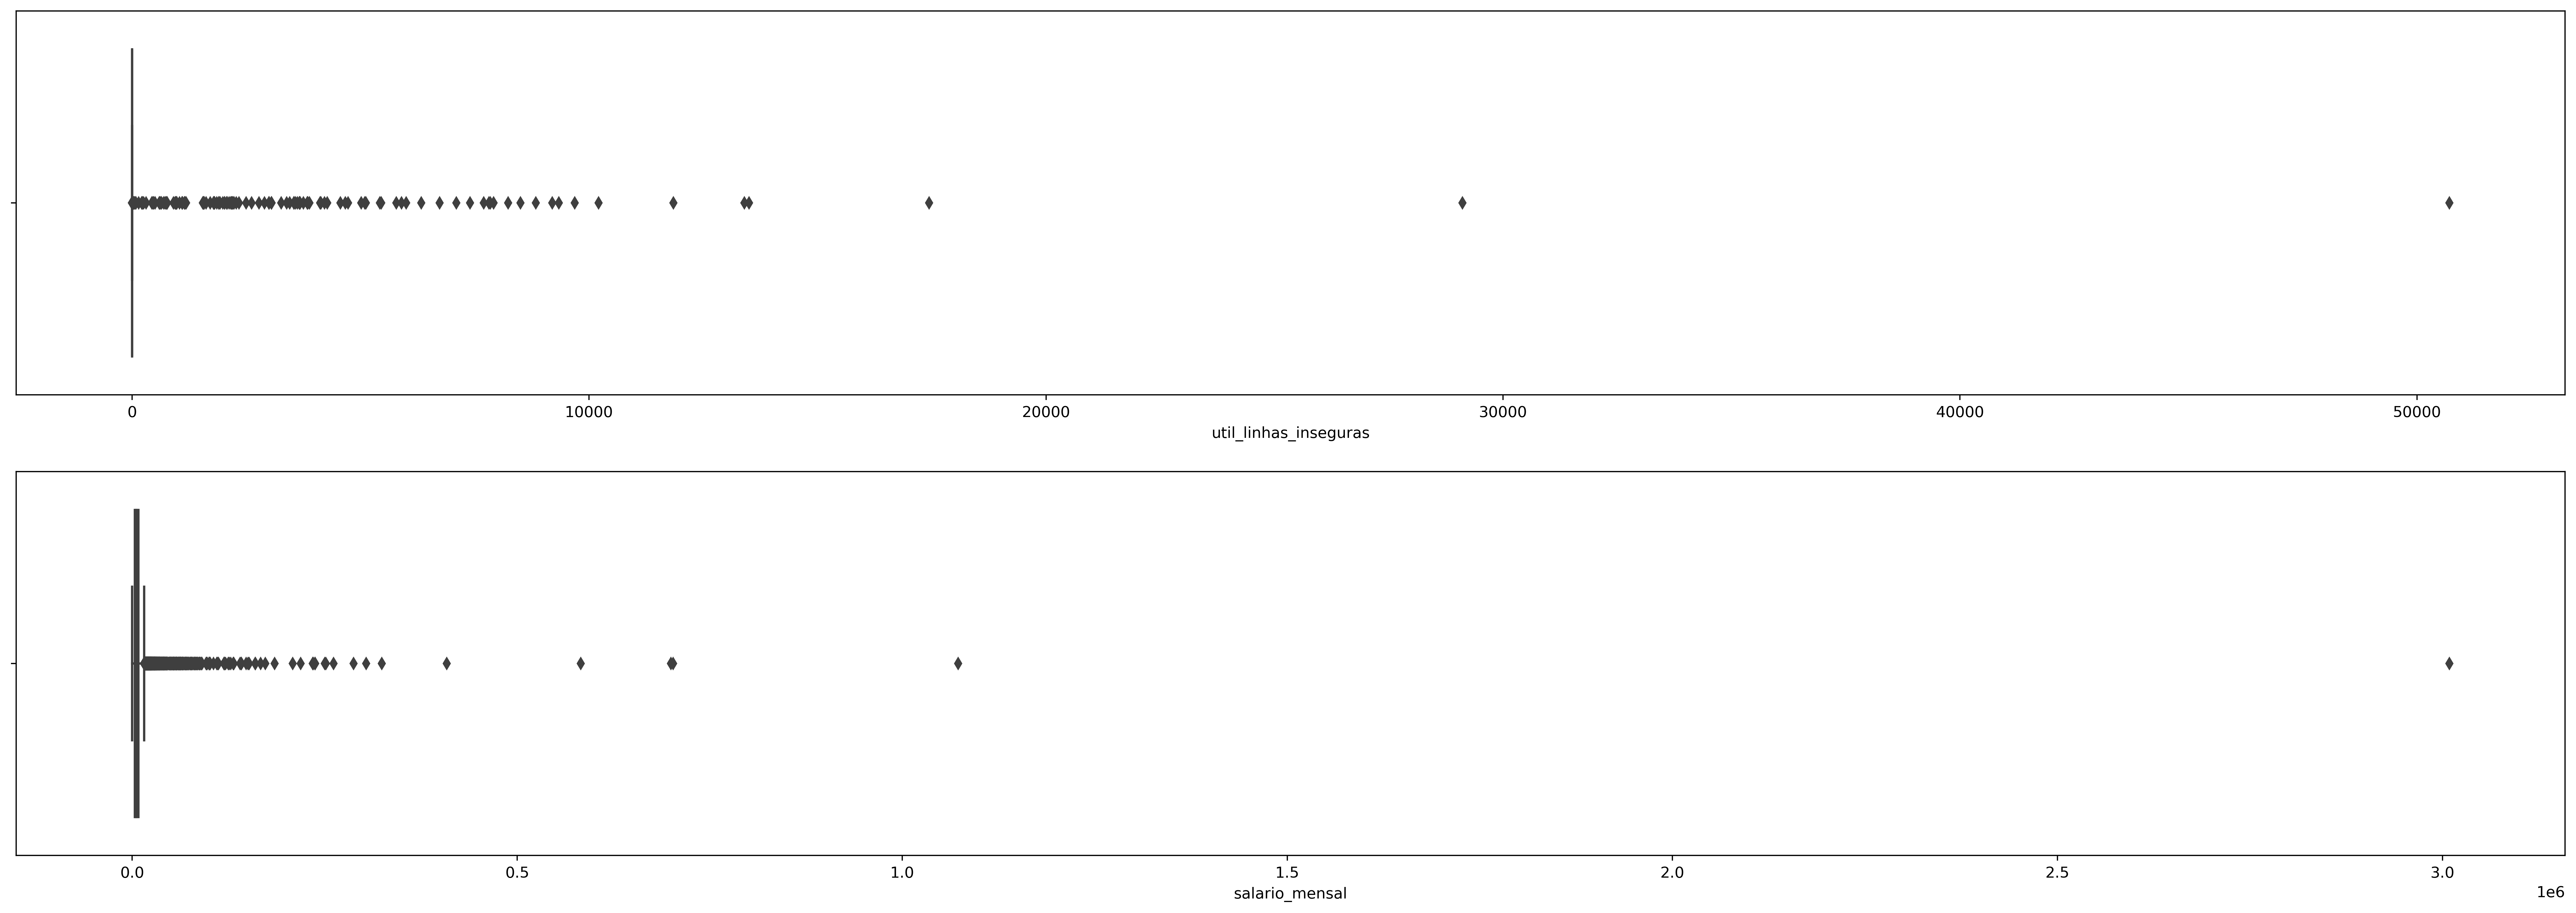

In [159]:
area = plt.figure(figsize=(30, 10), dpi=400)
plot_idd = area.add_subplot(2, 1, 1)
plot_idd = boxplot(treino_sem_outliers, x='util_linhas_inseguras')
plot_idd = area.add_subplot(2, 1, 2)
plot_idd = boxplot(treino_sem_outliers, x='salario_mensal')


In [160]:
treino_sem_outliers.describe()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
count,85864.000000,85864.000000,85864.000000,85864.000000,85864.000000,8.586400e+04,85864.000000,85864.000000,85864.000000,85864.000000,85864.000000
mean,0.069447,5.995848,50.384899,0.263661,26.444722,6.669653e+03,8.787909,0.092868,1.070996,0.067677,0.871075
std,0.254214,264.248263,13.488627,0.720393,327.360480,1.334693e+04,5.152943,0.486395,1.124217,0.337352,1.155441
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.037702,40.000000,0.000000,0.151170,3.429000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.186213,50.000000,0.000000,0.301653,5.416000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.590502,61.000000,0.000000,0.487269,8.300000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,50708.000000,80.000000,13.000000,25801.000000,3.008750e+06,57.000000,17.000000,20.000000,11.000000,20.000000


- Analisando o describe() nota-se que a media do util_linhas_inseguras é 6 e o máximo é 50708, portanto vou limitar esse valor para 100;
- Salario vai de 0 a 50k.

In [161]:
treino_sem_outliers = treino_sem_outliers.query(
    'util_linhas_inseguras<5').query('salario_mensal < 50000')


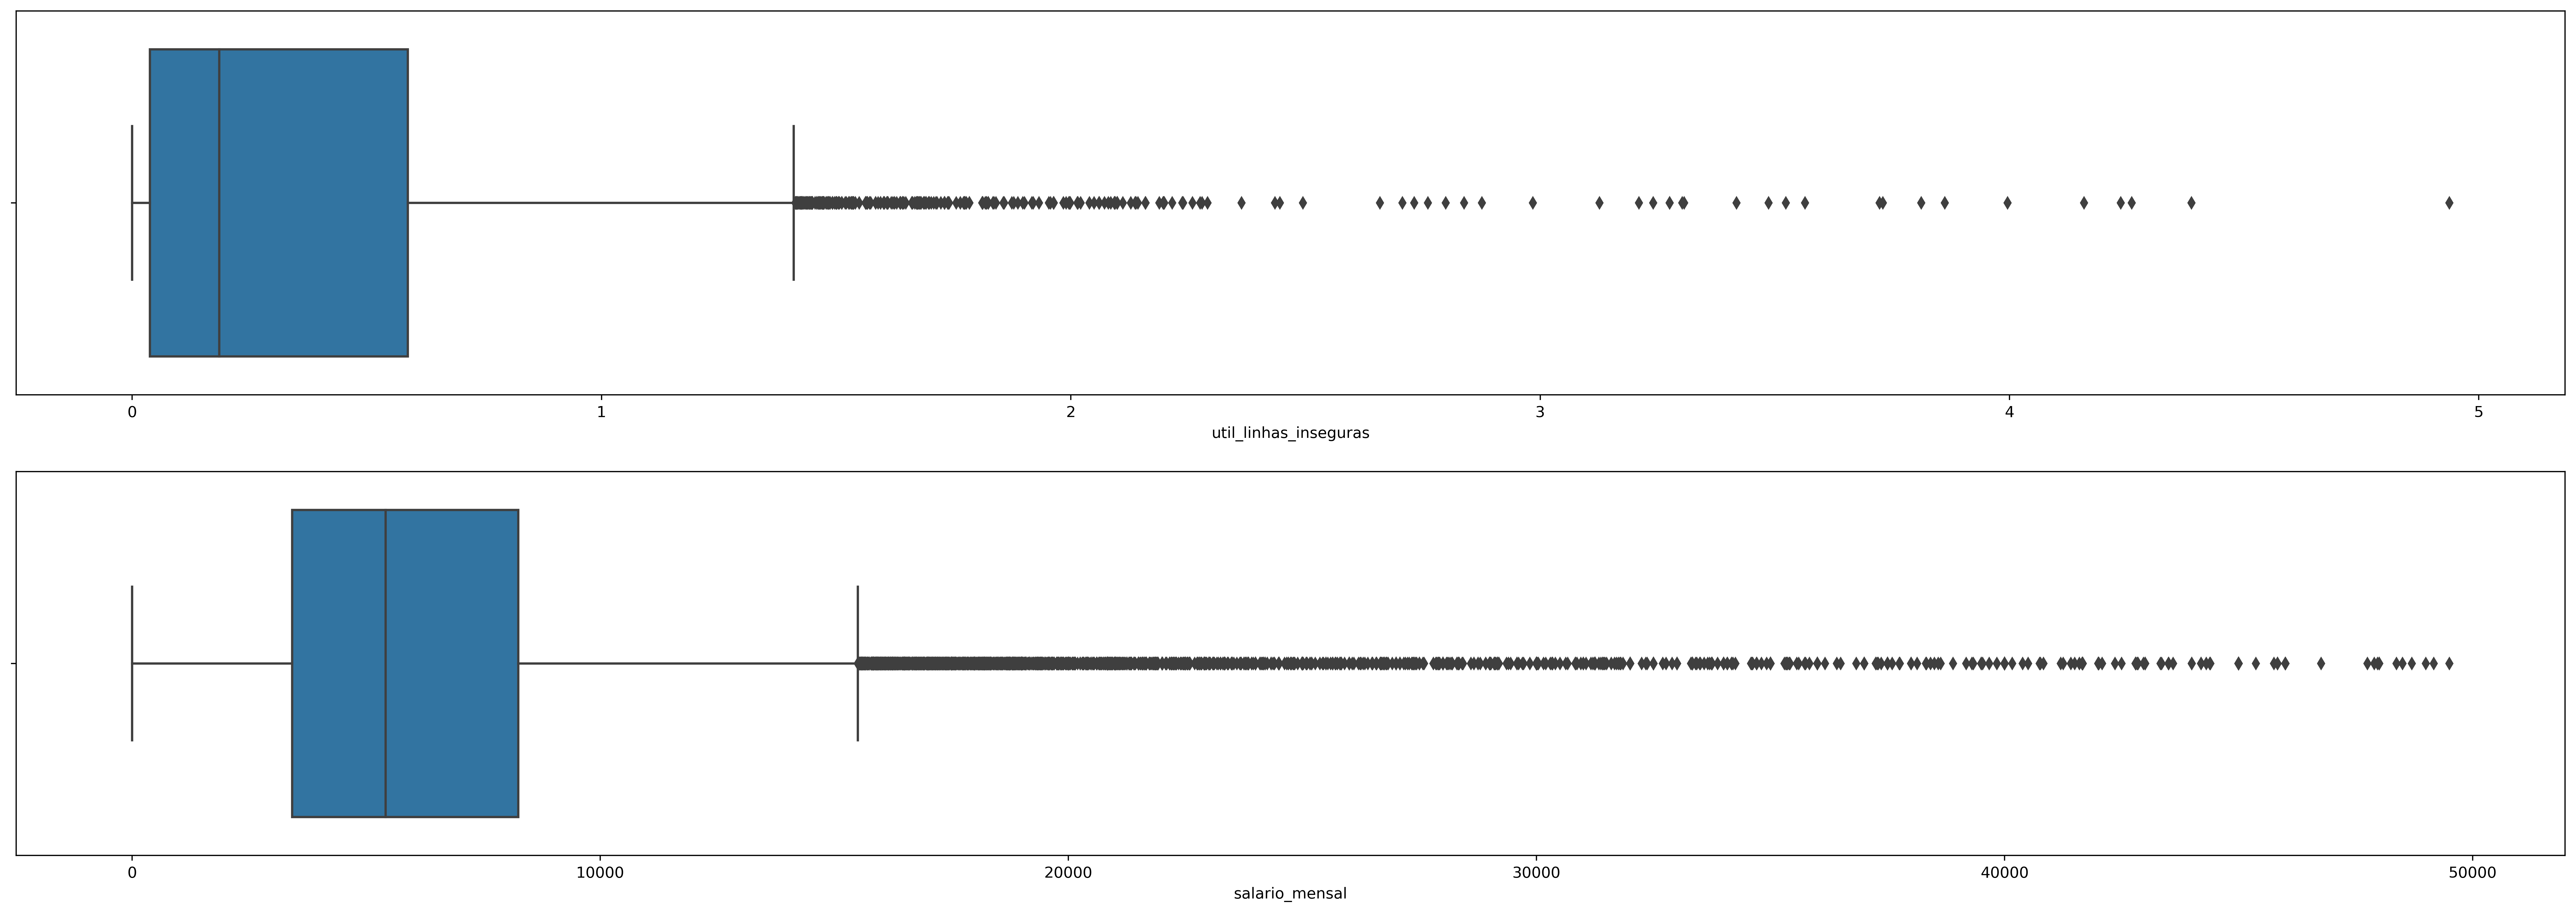

In [162]:
area = plt.figure(figsize=(30, 10), dpi=400)
plot_idd = area.add_subplot(2, 1, 1)
plot_idd = boxplot(treino_sem_outliers, x='util_linhas_inseguras')
plot_idd = area.add_subplot(2, 1, 2)
plot_idd = boxplot(treino_sem_outliers, x='salario_mensal')


##### Analisar correlação entre as variáveis

#### 4. Testes de Correlação entre as Features

<Axes: >

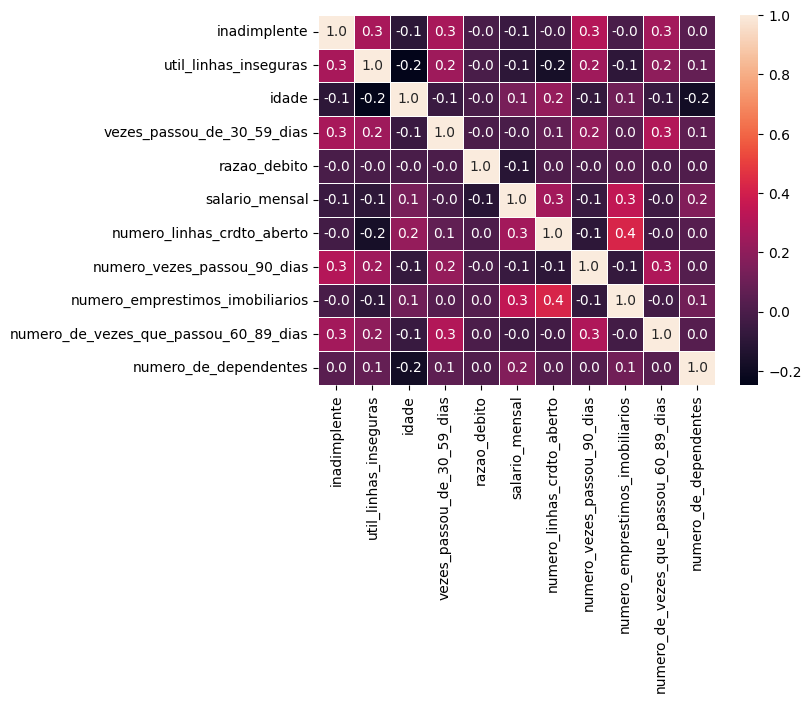

In [163]:
correlacao = treino_sem_outliers.corr()
plot = sns.heatmap(correlacao, annot=True, fmt=".1f", linewidths=.6)
plot


Analisando os resultados do gráfico de correlação vou retirar as seguintes Features do treino do modelo:
- razao_debito;
- numero_linhas_cdto_aberto;
- numero_emprestimos_imobiliarios;
- numero de dependentes
MOTIVO: Sem nenhum correlação com a variável resposta (inadimplente)

Nenhuma feature apresenta grande relação entre si, portanto não tirarei mais nenhuma do modelo.

#### 5. Normalizando as Features
Como as Features selecionadas possuem diferentes limites de valores, por exemplo: 
- Salário varia de 0 a 50k.
- idade varia de 20 a 80.
- quantidade de vezes passou 30_59 dias varia de 0 a 12.

Essas diferenças de variações podem ser prejudiciais ao modelo, e portanto vou normalizar algumas features.

Poderia normalizar usando a biblioteca Normalizer do SciKit Learn, mas me parece ser mais simples e eficaz aplica o log nas variáveis que aprensentam valores muito alto, como salario e idade.
Com essa transformação todos os valores ficariam variando na casa do 0 a 12. 

In [164]:
#Tirando os valores 0 da coluna salario_mensal:
treino_sem_outliers['salario'] = treino_sem_outliers['salario_mensal'].apply(lambda x: 1 if x==0 else x)

#Aplicando o log nas variáveis
treino_sem_outliers['log_salario'] = treino_sem_outliers['salario'].apply(lambda x: np.log10(x))
treino_sem_outliers['log_idade'] = treino_sem_outliers['idade'].apply(lambda x: np.log10(x))
treino_sem_outliers

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,salario,log_salario,log_idade
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,9120.0,3.959995,1.653213
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,2600.0,3.414973,1.602060
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,3042.0,3.483159,1.579784
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,3300.0,3.518514,1.477121
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1,3500.0,3.544068,1.869232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109992,0,0.006491,61,0,0.004570,3500.0,8,0,0,0,0,3500.0,3.544068,1.785330
109995,0,0.137396,59,1,0.448912,9600.0,10,0,2,0,0,9600.0,3.982271,1.770852
109996,0,0.276964,46,0,0.491288,12224.0,19,0,4,0,4,12224.0,4.087213,1.662758
109997,0,0.181257,43,0,0.382635,12000.0,13,0,2,0,2,12000.0,4.079181,1.633468


#### 6. Análise de Balanceamento dos dados
Essa sessão irá investigar e tratar possíveis desbalanceamento dos dados em questão.

In [198]:
print('Analisar a distribuição de valores de inadimplencia nos dados')
print(treino_sem_outliers.inadimplente.value_counts())

Analisar a distribuição de valores de inadimplencia nos dados
0    79567
1     5938
Name: inadimplente, dtype: int64


Vou tratar esses dados desbalanceados com a técnica de Under-Sampling, basicamente irei descartar algumas informações da classe majoritária.

In [200]:
# Separando variável resposta

y = treino_sem_outliers['inadimplente']
X = treino_sem_outliers[['util_linhas_inseguras', 'log_idade', 'vezes_passou_de_30_59_dias', 'log_salario',
                         'numero_vezes_passou_90_dias', 'numero_de_vezes_que_passou_60_89_dias']]
# Separando em treino e teste

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=20, stratify=y)

In [202]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)
print(pd.Series(y_res).value_counts())

0    4157
1    4157
Name: inadimplente, dtype: int64


#### 7. Treinando os Modelos

##### Dummy

In [214]:
modeloDummy = DummyClassifier(strategy='most_frequent')
modeloDummy.fit(X_res, y_res)
scoreDummy = modeloDummy.score(X_test, y_test)
print(f'O score para o modelo Dummy Classifier é {scoreDummy}')


O score para o modelo Dummy Classifier é 0.930570715733666


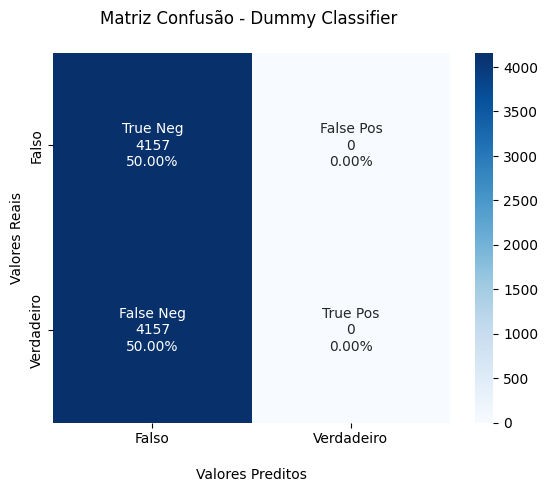

In [215]:
matriz_confusao('Dummy Classifier', modeloDummy, X_res, y_res)


##### Regressão Logística



In [216]:
modeloRL = LogisticRegression()
modeloRL.fit(X_res, y_res)
y_predicted = modeloRL.predict(X_test)
scoreRL = modeloRL.score(X_test, y_test)
print(f'O score para o modelo de Regressão Logística é {scoreRL}')


O score para o modelo de Regressão Logística é 0.7958443786059567


In [217]:
coeficientes_modelo(modeloRL, X_res,y_res)

O intercepto é [0.57175389]
Feature --> Coeficiente

util_linhas_inseguras --> 1.8494864832214275

log_idade --> -1.4189634498553663

vezes_passou_de_30_59_dias --> 0.6752752722249116

log_salario --> 0.07807730696986219

numero_vezes_passou_90_dias --> 0.8343015120665499

numero_de_vezes_que_passou_60_89_dias --> 0.9078309001905353



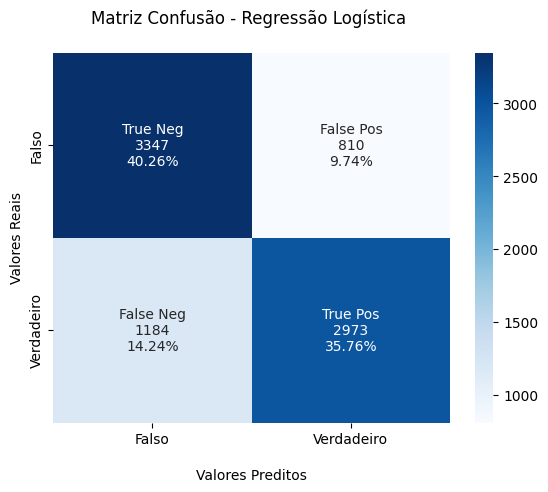

In [218]:
matriz_confusao('Regressão Logística', modeloRL, X_res, y_res)


#### KNN

In [206]:
modeloKNN = KNeighborsClassifier()
modeloKNN.fit(X_res, y_res)
scoreKNN = modeloKNN.score(X_test, y_test)
print(f'O score para o modelo de KNN é {scoreKNN}')


O score para o modelo de Regressão Logística é 0.7431779198503041


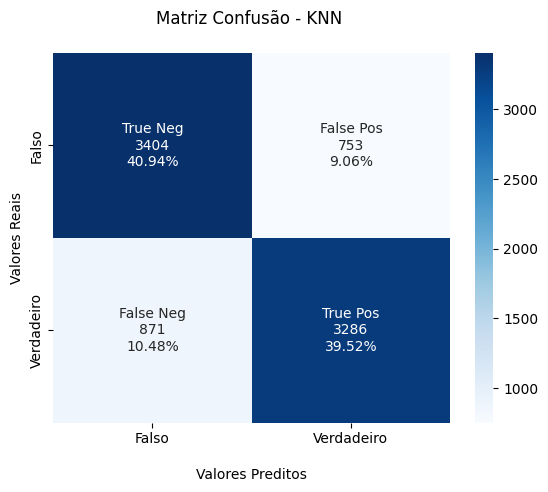

In [219]:
matriz_confusao('KNN', modeloKNN, X_res, y_res)


#### Decision Tree Classifier

In [208]:
modeloTree = DecisionTreeClassifier()
modeloTree.fit(X_res, y_res)
scoreTree = modeloTree.score(X_test, y_test)
print(f'O score para o modelo de Árvore de Decisão é {scoreTree}')


O score para o modelo de Árvore de Decisão é 0.6752689848744737


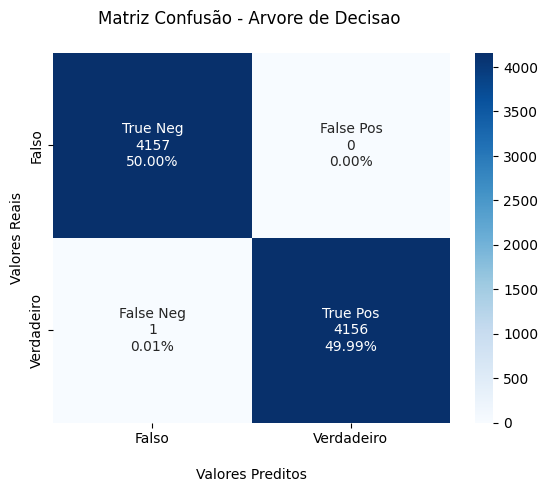

In [220]:
matriz_confusao('Arvore de Decisao', modeloTree, X_res, y_res)


#### Gaussian Naive Bayes

In [221]:
modeloGNB = GaussianNB()
modeloGNB.fit(X_res, y_res)
scoreGNB = modeloGNB.score(X_test, y_test)
print(f'O score para o modelo de Gaussian Naive Bayes é {scoreGNB}')


O score para o modelo de Gaussian Naive Bayes é 0.8909636675502884


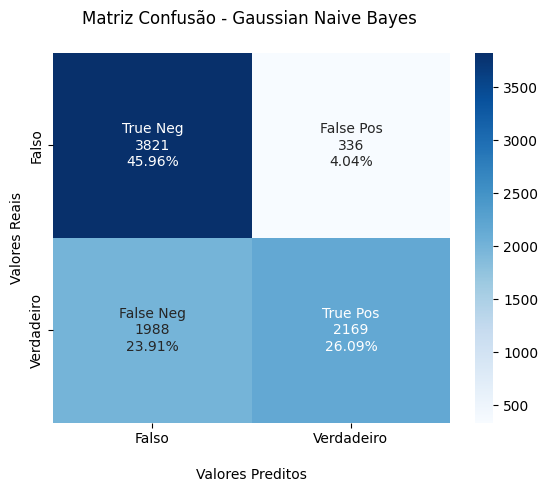

In [222]:
matriz_confusao('Gaussian Naive Bayes', modeloGNB, X_res, y_res)


#### Multinomial Naive Bayes

In [223]:
modeloMNB = MultinomialNB()
modeloMNB.fit(X_res, y_res)
scoreMNB = modeloMNB.score(X_test, y_test)
print(f'O score para o modelo de Multinomial Naive Bayes é {scoreMNB}')

O score para o modelo de Multinomial Naive Bayes é 0.866053329175113


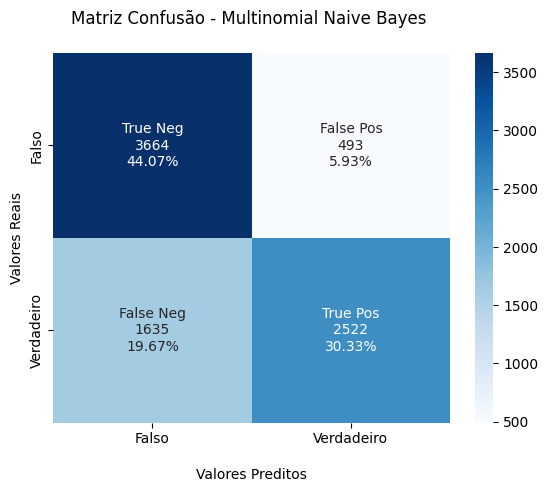

In [224]:
matriz_confusao('Multinomial Naive Bayes', modeloMNB, X_res, y_res)


#### 6. Refinamentos
Esse capítulo é para modificar os dados de entrada nos modelos e avaliar se ocorre uma melhoria de desempenho.
Dentre as alterações que serão feitas temos:
- Retirar todos os outliers do modelo;
- Aplicar a biblioteca de normalização nos dados ao inves de utilizar log10;
- Modificar alguns parametros de entrada dos modelos;

##### 6.1 Treino sem Outliers

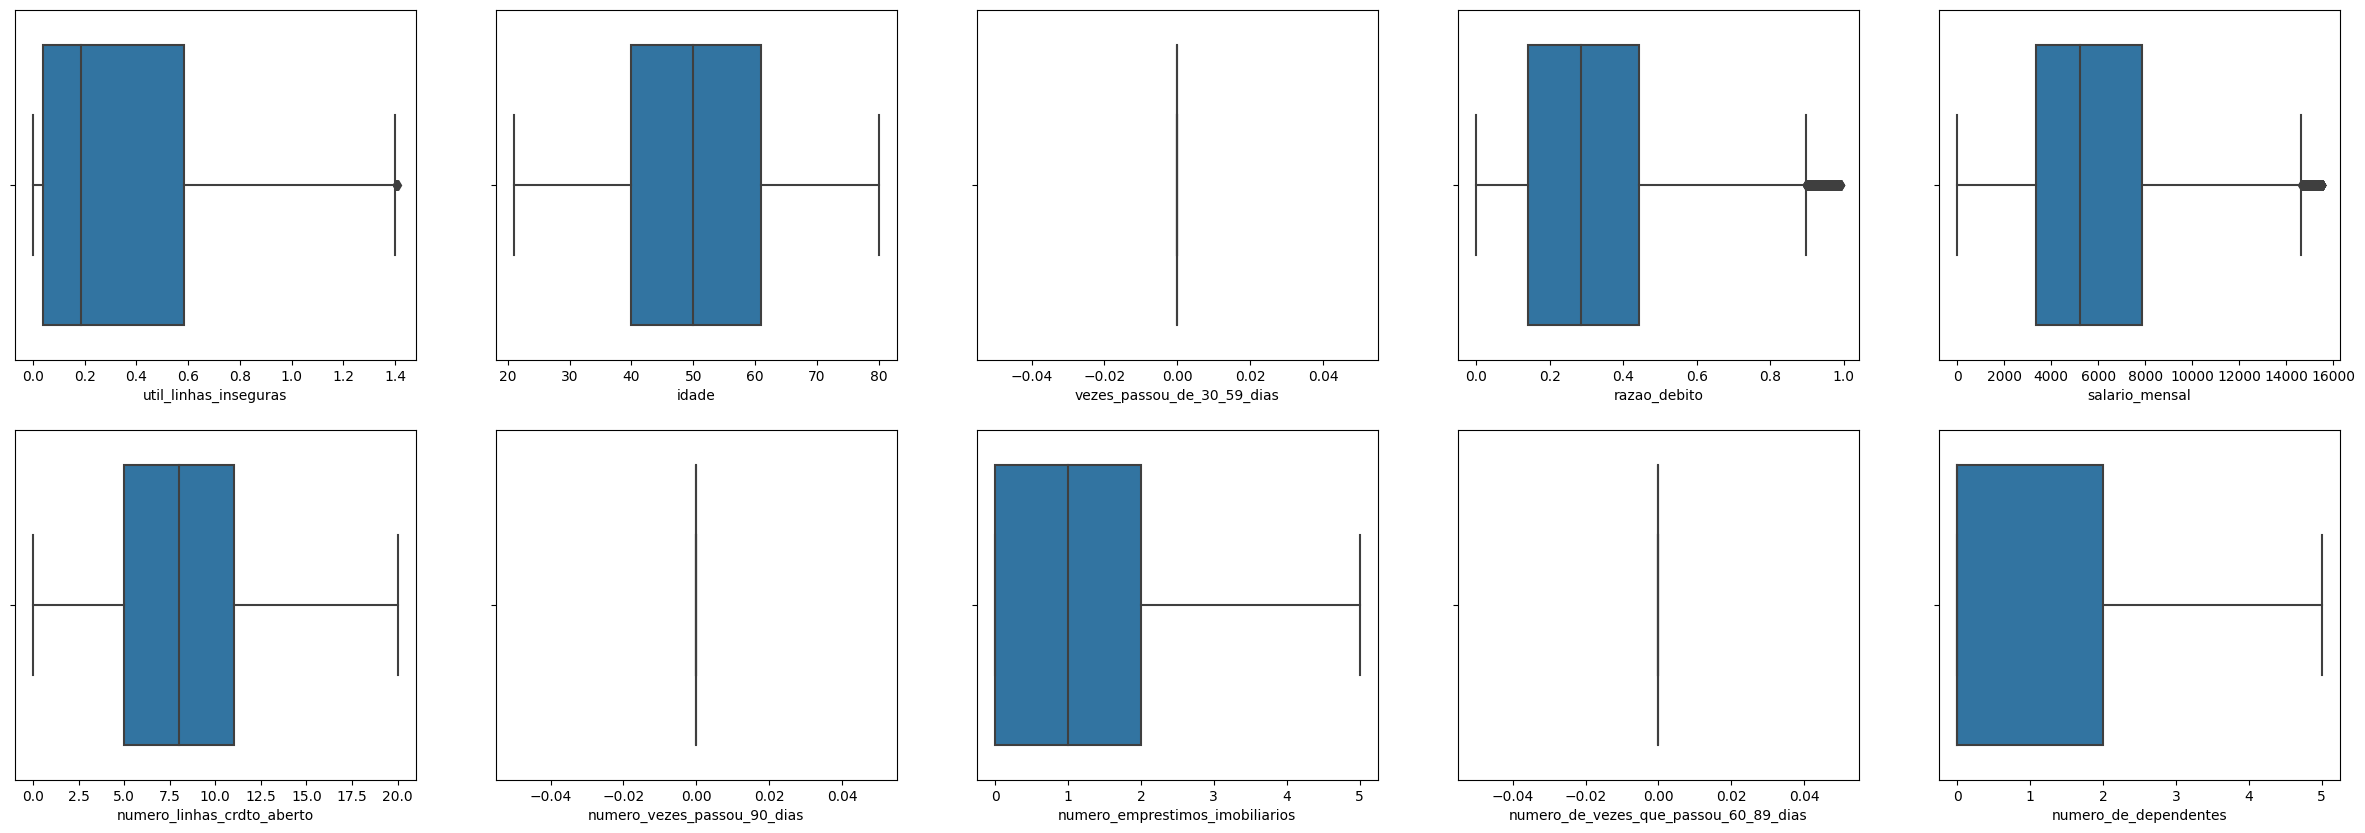

In [180]:
listaVerdade = Remove_Outlier_Indices(treino_sem_outliers)
treino_sem_outliers_totais = treino_sem_outliers[listaVerdade]
area = plt.figure(figsize=(30, 10), dpi=100)
plot_idd = area.add_subplot(2, 5, 1)
plot_idd = boxplot(treino_sem_outliers_totais, x='util_linhas_inseguras')

# plot_idd.set_ylabel('Idade (anos)')
plot_func = area.add_subplot(2, 5, 2)
boxplot(treino_sem_outliers_totais, x='idade')

plot_meses = area.add_subplot(2, 5, 3)
boxplot(treino_sem_outliers_totais, x='vezes_passou_de_30_59_dias')

plot_meses = area.add_subplot(2, 5, 4)
boxplot(treino_sem_outliers_totais, x='razao_debito')

plot_meses = area.add_subplot(2, 5, 5)
boxplot(treino_sem_outliers_totais, x='salario_mensal')

plot_meses = area.add_subplot(2, 5, 6)
boxplot(treino_sem_outliers_totais, x='numero_linhas_crdto_aberto')

plot_meses = area.add_subplot(2, 5, 7)
boxplot(treino_sem_outliers_totais, x='numero_vezes_passou_90_dias')

plot_meses = area.add_subplot(2, 5, 8)
boxplot(treino_sem_outliers_totais, x='numero_emprestimos_imobiliarios')

plot_meses = area.add_subplot(2, 5, 9)
boxplot(treino_sem_outliers_totais, x='numero_de_vezes_que_passou_60_89_dias')

plot_meses = area.add_subplot(2, 5, 10)
boxplot(treino_sem_outliers_totais, x='numero_de_dependentes')


In [182]:
treino_sem_outliers_totais = treino_sem_outliers_totais.dropna()
# Tirando os valores 0 da coluna salario_mensal:
treino_sem_outliers_totais['salario'] = treino_sem_outliers_totais['salario_mensal'].apply(lambda x: 1 if x == 0 else x)

# Aplicando o log nas variáveis
treino_sem_outliers_totais['log_salario'] = treino_sem_outliers_totais['salario'].apply(lambda x: np.log10(x))
treino_sem_outliers_totais['log_idade'] = treino_sem_outliers_totais['idade'].apply(lambda x: np.log10(x))

#Aplicando modelo:
from sklearn.model_selection import train_test_split
y_1 = treino_sem_outliers_totais['inadimplente']
X_1 = treino_sem_outliers_totais[['util_linhas_inseguras', 'log_idade', 'vezes_passou_de_30_59_dias', 'log_salario',
                         'numero_vezes_passou_90_dias', 'numero_de_vezes_que_passou_60_89_dias']]

# Separando em treino e teste
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1, y_1, test_size=0.3, random_state=20, stratify=y_1)


In [183]:
# Aplicando Modelos
dummyClasifier(X_train_1, y_train_1, X_test_1, y_test_1)
# regressaoLogistica(X_train_1, y_train_1, X_test_1, y_test_1)
# KNNClassifier(X_train_1, y_train_1, X_test_1, y_test_1)
# decisionTree(X_train_1, y_train_1, X_test_1, y_test_1)
# gaussianNB(X_train_1, y_train_1, X_test_1, y_test_1)
# multinomialNB(X_train_1, y_train_1, X_test_1, y_test_1)

#ERRO! Tirando todos os outliers não sobrou variavel resposta igual a 1.
print(f'Soma da variavel resposta de treino --> {y_train_1.sum()}.')
print(f'Soma da variavel resposta de teste --> {y_test_1.sum()}.')



O score para o modelo Dummy Classifier é 1.0
Soma da variavel resposta de treino --> 0.0.
Soma da variavel resposta de teste --> 0.0.


##### 6.2 Biblioteca de normalização

In [191]:
#Usando o StandartScaler
scaler = StandardScaler()
scaler.fit(dados_completos)
dados_com_scaler = scaler.fit_transform(dados_completos)

df_scaled = pd.DataFrame(dados_com_scaler, columns=dados_completos.columns)


y_2 = treino_sem_outliers_totais['inadimplente']
X_2 = treino_sem_outliers_totais[['util_linhas_inseguras', 'log_idade', 'vezes_passou_de_30_59_dias', 'log_salario',
                                  'numero_vezes_passou_90_dias', 'numero_de_vezes_que_passou_60_89_dias']]

# Separando em treino e teste
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.3, random_state=20, stratify=y_2)

# Aplicando Modelos
dummyClasifier(X_train_2, y_train_2, X_test_2, y_test_2)
regressaoLogistica(X_train_2, y_train_2, X_test_2, y_test_2)
KNNClassifier(X_train_2, y_train_2, X_test_2, y_test_2)
decisionTree(X_train_2, y_train_2, X_test_2, y_test_2)
gaussianNB(X_train_2, y_train_2, X_test_2, y_test_2)
multinomialNB(X_train_2, y_train_2, X_test_2, y_test_2)


O score para o modelo Dummy Classifier é 1.0


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0